In [203]:
from pyhdf.SD import SD, SDC
import os
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pyproj
import cartopy.crs as ccrs

folder = "/uio/hume/student-u37/fslippe/data/land_sea_ice_mask/"

ds = (xr.open_dataset(folder + "NSIDC-0780_SeaIceRegions_PS-N3.125km_v1.0.nc"))


# Define a function to convert Polar Stereographic coordinates to lon, lat
def transform_polar_stereo_to_lonlat(x, y):
    proj = pyproj.Transformer.from_crs(
        pyproj.CRS('EPSG:3411'),  # Polar Stereographic North
        pyproj.CRS('EPSG:4326'),  # WGS84 coordinate system
        always_xy=True
    )
    return proj.transform(x, y)

# Get the x, y meshgrid from the dataset
x, y = np.meshgrid(ds['x'], ds['y'])

# Convert x, y to longitude and latitude
longitude, latitude = transform_polar_stereo_to_lonlat(x, y)

# Add the resulting longitude and latitude arrays to the dataset
ds['longitude'] = (('y', 'x'), longitude)
ds['latitude'] = (('y', 'x'), latitude)
ds


<xarray.Dataset>
Dimensions:                      (y: 3584, x: 2432)
Coordinates:
  * x                            (x) float32 -3.848e+06 -3.845e+06 ... 3.748e+06
  * y                            (y) float32 5.848e+06 5.845e+06 ... -5.348e+06
Data variables:
    sea_ice_region               (y, x) float32 ...
    sea_ice_region_surface_mask  (y, x) float32 ...
    crs                          object ...
    longitude                    (y, x) float64 168.3 168.3 ... -9.998 -9.975
    latitude                     (y, x) float64 31.0 31.01 31.02 ... 34.37 34.36
Attributes: (12/27)
    title:                    Geographic regions for sea ice for the 3.125km ...
    summary:                  This file provides a description of regions use...
    acknowledgment:           These data are produced and supported by the NA...
    id:                       10.5067/CYW3O8ZUNIWC
    naming_authority:         org.doi.dx
    standard_name_authority:  CF Standard Name Table (v77, 19 January 2021)
    ...                       ...
    geospatial_lat_min:       30.98
    geospatial_lat_max:       90.0
    geospatial_lat_units:     degrees_north
    geospatial_lon_min:       -180.0
    geospatial_lon_max:       180.0
    geospatial_lon_units:     degrees_east

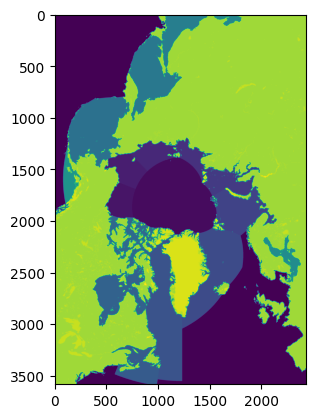

In [206]:
plt.imshow(ds["sea_ice_region_surface_mask"])

<xarray.Dataset>
Dimensions:                      (y: 1030, x: 1020)
Coordinates:
  * x                            (x) float32 8.906e+04 9.219e+04 ... 3.273e+06
  * y                            (y) float32 -8.906e+04 ... -3.305e+06
Data variables:
    sea_ice_region_surface_mask  (y, x) int64 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0
    longitude                    (y, x) float64 -5.026e-06 0.9878 ... -0.2722
    latitude                     (y, x) float64 88.84 88.82 88.8 ... 48.87 48.85
Attributes: (12/27)
    title:                    Geographic regions for sea ice for the 3.125km ...
    summary:                  This file provides a description of regions use...
    acknowledgment:           These data are produced and supported by the NA...
    id:                       10.5067/CYW3O8ZUNIWC
    naming_authority:         org.doi.dx
    standard_name_authority:  CF Standard Name Table (v77, 19 January 2021)
    ...                       ...
    geospatial_lat_min:       30.98
    geospatial_lat_max:       90.0
    geospatial_lat_units:     degrees_north
    geospatial_lon_min:       -180.0
    geospatial_lon_max:       180.0
    geospatial_lon_units:     degrees_east

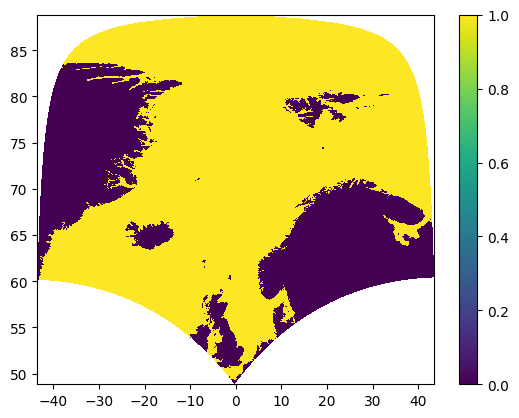

In [202]:

ds_i = ds.isel(y=slice(1900, 2930), x=slice(1260, 2280))
land_mask = ds_i.sea_ice_region_surface_mask < 17
ds_i["sea_ice_region_surface_mask"] = xr.where(land_mask, 1, 0)


cb = plt.pcolormesh(ds_i.longitude, ds_i.latitude, ds_i["sea_ice_region_surface_mask"])
plt.colorbar(cb)
ds_i = ds_i.drop_vars(["sea_ice_region", "crs"])
ds_i.to_netcdf(folder + "sea_land_mask.nc")
ds_i

In [ ]:
from scipy.ndimage import zoom

hdf = SD("/scratch/fslippe/modis/MOD02/cao_test_data/MOD021KM.A2023062.1425.061.2023063012221.hdf", SDC.READ)
data = hdf.select("EV_1KM_Emissive")[:][0]

lat = hdf.select("Latitude")[:]
lon = hdf.select("Longitude")[:]
lon_min, lon_max = -35, 35
lat_min, lat_max = 60, 82

mask_lowres = (lat >= lat_min) & (lat <= lat_max) & (lon > lon_min) & (lon < lon_max)
zoom_factor_y = data.shape[0] / lat.shape[0]
zoom_factor_x = data.shape[1] / lat.shape[1]
zoom_factors = (zoom_factor_y, zoom_factor_x)  # Now considering only 2 dimensions
mask_highres = zoom(mask_lowres, zoom_factors, order=0)  # order=0 for nearest neighbor interpolation
lat_highres = zoom(lat, zoom_factors, order=0)  # order=1 for bilinear interpolation
lon_highres = zoom(lon, zoom_factors, order=0) 
valid_rows_ll = np.any(mask_highres, axis=1)
valid_cols_ll = np.any(mask_highres, axis=0)
data = data[valid_rows_ll][:, valid_cols_ll]
lat_highres = lat_highres[valid_rows_ll][:, valid_cols_ll] 
lon_highres = lon_highres[valid_rows_ll][:, valid_cols_ll] 


In [ ]:
ds_s = ds.copy(deep=True)
land_mask = ds.sea_ice_region_surface_mask < 17
ds_s["sea_ice_region_surface_mask"] = ds_s["sea_ice_region_surface_mask"].where(land_mask)

In [174]:
from scipy.spatial import cKDTree

# Create a KDTree for the low-resolution coordinates
coords_lowres = np.column_stack((ds_i.latitude.values.ravel(), ds_i.longitude.values.ravel()))
tree = cKDTree(coords_lowres)

# Flatten the high-resolution coordinate arrays and stack them
coords_highres = np.column_stack((lat_highres.ravel(), lon_highres.ravel()))

# Query the tree for the index of the nearest neighbor in the low-res grid for each point in the high-res grid
distances, indices = tree.query(coords_highres, k=1)

# Use the indices to fetch the corresponding values from ds_i and reshape to the original data shape
mask = ds_i["sea_ice_region_surface_mask"].values.ravel()[indices].reshape(data.shape)


/tmp/ipykernel_2407686/4065706422.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(lon_highres, lat_highres, np.where(mask == 1, data, np.nan))


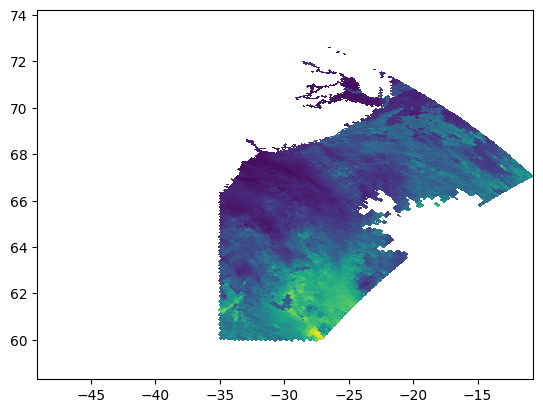

In [177]:
plt.pcolormesh(lon_highres, lat_highres, np.where(mask == 1, data, np.nan))

array([[  nan,   nan,   nan, ..., 8262., 8101., 8253.],
       [  nan,   nan,   nan, ..., 8506., 8011., 8330.],
       [  nan,   nan,   nan, ..., 8283., 8107., 8250.],
       ...,
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan],
       [  nan,   nan,   nan, ...,   nan,   nan,   nan]])

In [ ]:
mask = np.empty(data.shape)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        lon_dist = 111.111*np.sin(np.radians(lat_highres[i, j]))*(lon_highres[i, j] - ds_s.longitude)
        lat_dist = 111.111*(lat_highres[i, j] - ds_s.latitude)
        dist = lon_dist**2 + lat_dist**2    
        print(dist)
        mask[i, j] = ds_s["sea_ice_region_surface_mask"][np.unravel_index(np.argmin(dist.to_numpy), dist.shape)]
        print(mask[i, j])

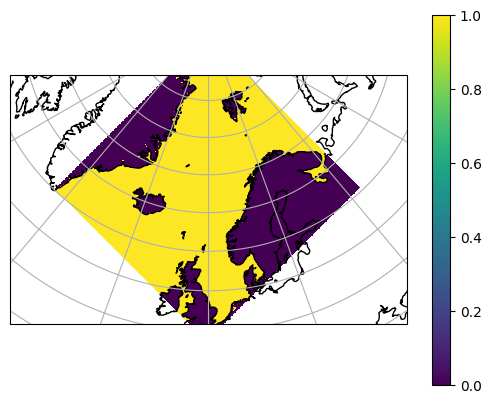

In [200]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.NorthPolarStereo()})

# Plot the data with the proper coordinates and color mapping
c = ax.pcolormesh(ds_i.longitude, ds_i.latitude, ds_i["sea_ice_region_surface_mask"], transform=ccrs.PlateCarree())
ax.set_extent([-35, 35, 45, 82])
# Add coastlines and gridlines for better visualization
ax.coastlines()
ax.gridlines()

plt.colorbar(c, ax=ax, label="")
plt.show()

In [ ]:
desired_lon, desired_lat= -5, 60  # example lon/lat values
x, y = pyproj.transform(lonlat_crs, data_crs, desired_lon, desired_lat)

# Extract the value from the dataset using the nearest x, y
value = ds['sea_ice_region'].sel(x=x, y=y, method='nearest').values

print(value)


 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
30
32
33
34
35
"""
ocean_no_region_specified 0
central_arctic 1
beaufort_sea 2
chukchi_sea 3
east_siberian_sea 4
laptev_sea 5
kara_sea 6
barents_sea 7
east_greenland_sea 8
baffin_bay_and_labrador_seas 9
gulf_of_st_lawrence 10 
hudson_bay 11
canadian_archipelago 12
bering_sea 13
sea_of_okhotsk 14
sea_of_japan 15
bohai_and_yellow_seas 16
baltic_sea 17
gulf_of_alaska 18
"""
